In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
stations_df = pd.read_pickle('../../Dataset/MyMethod/DailyStations_Interpolated.pkl')
stations_df.head()

,Station_Name,Transactions
0,BOULDER / JUNCTION ST1,Energy__kWh_ Year Month W...
1,BOULDER / ALPINE ST1,Energy__kWh_ Year Month ...
2,BOULDER / BASELINE ST1,Energy__kWh_ Year Month ...
3,BOULDER / FACILITIES ST1,Energy__kWh_ Year Month ...
4,COMM VITALITY / 1500PEARL2,Energy__kWh_ Year Month W...


In [3]:
stations_df['Transactions'].apply(lambda x: x.isna().sum()).all()

Energy__kWh_                         False
Year                                 False
Month                                False
Weekday                              False
Maximum T                            False
Minimum T                            False
Precipitation                        False
Snow                                 False
Charging_Time_min                    False
Remaining_Park_After_Charge_(min)    False
dtype: bool

In [4]:
stations_df.loc[1,'Transactions'].columns

Index(['Energy__kWh_', 'Year', 'Month', 'Weekday', 'Maximum T', 'Minimum T',
       'Precipitation', 'Snow', 'Charging_Time_min',
       'Remaining_Park_After_Charge_(min)'],
      dtype='object')

### **Preprocessing**

In [5]:
sep = int(len(stations_df)*0.8)

stations_train = stations_df[:sep]
stations_test = stations_df[sep:]

print('The Train Dataset contains', len(stations_train), 'stations')
print('The Test Dataset contains', len(stations_test), 'stations')

The Train Dataset contains 31 stations
The Test Dataset contains 8 stations


**Create Sequences & Scaling them for the training dataset**

In [6]:
features = ['Energy__kWh_', 'Month', 'Weekday', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow']

X_train = [] # Array with every mini trajectory input init
Y_train = [] # 1D Array with the target Energy__kWh_
T = 14 # Time window
D = len(features) # Number of dimensions

for group_df in stations_train['Transactions']:
    group_df = group_df[features]

    for t in range(0, len(group_df) - T):
        X_train.append(group_df.iloc[t:t+T])
        Y_train.append(group_df.iloc[t+T][['Energy__kWh_','Maximum T', 'Minimum T', 'Precipitation', 'Snow']])


N = len(X_train)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train.shape, Y_train.shape

((47193, 14, 7), (47193, 5))

Scaling the X_train

In [7]:
# Find the indices of numerical columns
numerical_indices = [i for i in range(X_train.shape[2]) if np.issubdtype(type(X_train[0, 0, i]), np.number)]

# Find the indices of non-numerical columns
categorical_indices = [i for i in range(X_train.shape[2]) if i not in numerical_indices]

print("Numerical column indices:", numerical_indices)
print("Non-numerical column indices:", categorical_indices)

Numerical column indices: [0, 3, 4, 5, 6]
Non-numerical column indices: [1, 2]


In [8]:
# Create transformers for numerical and categorical columns
numerical_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(sparse=False)

# Create a column transformer to apply transformers to the specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

# Create a pipeline to apply the column transformer
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform X_train using the pipeline
X_train_scaled = pipeline.fit_transform(X_train.reshape(-1, D))

# Reshape the result back to the original shape
X_train_scaled = X_train_scaled.reshape(N, T, -1)

Scaling the Y_train

In [9]:
# Get the fitted MinMaxScaler for X_train
x_scaler = pipeline.named_steps['preprocessor'].named_transformers_['num']
numerical_D = len(numerical_indices)

# Reshape Y_train to (N, D) before applying the transformation
Y_train_reshaped = Y_train.reshape(N, -1)

# Use the fitted parameters of X_train scaler to transform Y_train
Y_train_scaled = x_scaler.transform(Y_train_reshaped)

# Reshape the result back to the original shape
Y_train_scaled = Y_train_scaled.reshape(N, -1, numerical_D)

# Keep only the energy column (target) in the reshaped Y_train
Y_train_scaled = Y_train_scaled[:, :T, 0]

print("scaled X_train shape:", X_train_scaled.shape)
print("scaled Y_train shape:", Y_train_scaled.shape)

scaled X_train shape: (47193, 14, 24)
scaled Y_train shape: (47193, 1)


**Create Sequences & Scaling them for the testing dataset**

In [10]:
X_test = [] #Array with every mini trajectory input init
Y_test = [] #1D Array with the targets energy

for group_df in stations_test['Transactions']:
    group_df = group_df[features]

    for t in range(0,len(group_df) - T):
        X_test.append(group_df.iloc[t:t+T])
        Y_test.append(group_df.iloc[t+T][['Energy__kWh_','Maximum T', 'Minimum T', 'Precipitation', 'Snow']])


N = len(X_test)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test.shape, Y_test.shape

((1528, 14, 7), (1528, 5))

Scaling the Y_train and Y_test accord to X_train scalers

In [11]:
# Reshape X_test to a 2D array
X_test_reshaped = X_test.reshape(-1, D)

# Use the fitted parameters of X_train scaled to transform X_test
X_test_scaled = pipeline.transform(X_test_reshaped)

# Reshape the result back to the original shape
X_test_scaled = X_test_scaled.reshape(N, T, -1)

In [12]:
# Reshape Y_test to (N, D) before applying the transformation
Y_test_reshaped = Y_test.reshape(N, -1)

# Use the fitted parameters of X_train scaler to transform Y_test
Y_test_scaled = x_scaler.transform(Y_test_reshaped)

# Reshape the result back to the original shape
Y_test_scaled = Y_test_scaled.reshape(N, -1, numerical_D)

# Keep only the energy column (target) in the reshaped Y_test
Y_test_scaled = Y_test_scaled[:, :T, 0]

print("scaled X_test shape:", X_test_scaled.shape)
print("scaled Y_test shape:", Y_test_scaled.shape)

scaled X_test shape: (1528, 14, 24)
scaled Y_test shape: (1528, 1)


In [13]:
X_train_scaled[:1][0][1]

array([0.08894234, 0.07302905, 0.10897436, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        ])

In [14]:
Y_train_scaled[:4]

array([[0.08687814],
       [0.0835376 ],
       [0.08098493],
       [0.07843227]])

In [15]:
X_test_scaled[:1][0][1]

array([3.64008445e-02, 2.34439834e-02, 9.26816239e-02, 6.08766234e-04,
       1.96232339e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [16]:
Y_test_scaled[:4]

array([[0.03620347],
       [0.03621608],
       [0.0362287 ],
       [0.03624131]])

### **Build the GRU Model**

**loss function**

In [17]:
def root_mean_squared_error(y_true, y_pred):
        return tf.keras.backend.sqrt(
                tf.keras.backend.mean(
                        tf.keras.backend.square(
                                y_pred - y_true
                        )
                ) + 
                1e-9
        )

**Model Architecture**

In [33]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(24,activation= 'relu', recurrent_dropout= 0.1, kernel_regularizer= 'l2')),   
        tf.keras.layers.Dense(1),
    ]
)

model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1, clipvalue=1.0))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 48)               7200      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
_________________________________________________________________


**learning rate schedule**

In [34]:
def lr_schedule(epoch):
    initial_lr = 0.01
    drop = 0.5 
    epochs_drop = 7

    lr = initial_lr * (drop ** (epoch // epochs_drop))
    
    return lr

#This means that the lr drops at half every 7 epochs.

lr_scheduler = LearningRateScheduler(lr_schedule)

In [35]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(
    x = X_train_scaled,
    y = Y_train_scaled,
    epochs=250,
    batch_size= 16,
    callbacks=[lr_scheduler,early_stop],
    verbose=1,
    validation_data=(X_test_scaled,Y_test_scaled)
)

Epoch 1/250
2950/2950 [==============================] - 60s 18ms/step - loss: 0.0752 - val_loss: 0.0777 - lr: 0.0100
Epoch 2/250
2950/2950 [==============================] - 52s 18ms/step - loss: 0.0702 - val_loss: 0.0724 - lr: 0.0100
Epoch 3/250
2950/2950 [==============================] - 51s 17ms/step - loss: 0.0700 - val_loss: 0.0811 - lr: 0.0100
Epoch 4/250
2950/2950 [==============================] - 52s 18ms/step - loss: 0.0702 - val_loss: 0.0744 - lr: 0.0100
Epoch 5/250
2950/2950 [==============================] - 51s 17ms/step - loss: 0.0703 - val_loss: 0.0761 - lr: 0.0100
Epoch 6/250
2950/2950 [==============================] - 52s 18ms/step - loss: 0.0702 - val_loss: 0.0737 - lr: 0.0100
Epoch 7/250
2950/2950 [==============================] - 52s 18ms/step - loss: 0.0701 - val_loss: 0.0762 - lr: 0.0100
Epoch 8/250
2950/2950 [==============================] - 52s 18ms/step - loss: 0.0670 - val_loss: 0.0728 - lr: 0.0050
Epoch 9/250
2950/2950 [==============================] -

### **Evaluate the Model**

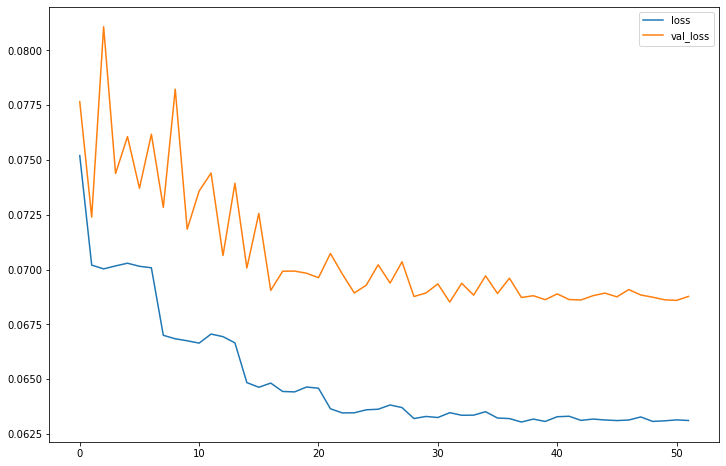

In [36]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label= 'loss')
plt.plot(history.history['val_loss'], label= 'val_loss')
plt.legend()
plt.show()

In [38]:
# Source: https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9/revisions

def calculate_nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    return nrmse

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Generate predictions using the model
y_pred = model(X_test_scaled)

# Inverse transform the scaled predictions to the original scale
inversed_y_pred = x_scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], numerical_D-1))], axis=1))
inversed_y_pred = inversed_y_pred[:, 0]

# Assuming y_pred and inversed_y_pred are NumPy arrays
inversed_y_pred_tensor = tf.convert_to_tensor(inversed_y_pred, dtype=tf.float32)

# Calculate RMSE
rmse = calculate_rmse(Y_test[:, 0], inversed_y_pred)

# Calculate NRMSE
nrmse = calculate_nrmse(Y_test[:, 0], inversed_y_pred)

# Calculate MAE
mae= calculate_mae(Y_test[:, 0], inversed_y_pred)


# Print the results
print(f"RMSE: {rmse}")
print(f"NRMSE: {nrmse}")
print(f'MAE: {mae}')

RMSE: 14.85068406877423
NRMSE: 0.1387797668305865
MAE: 10.266905903176253


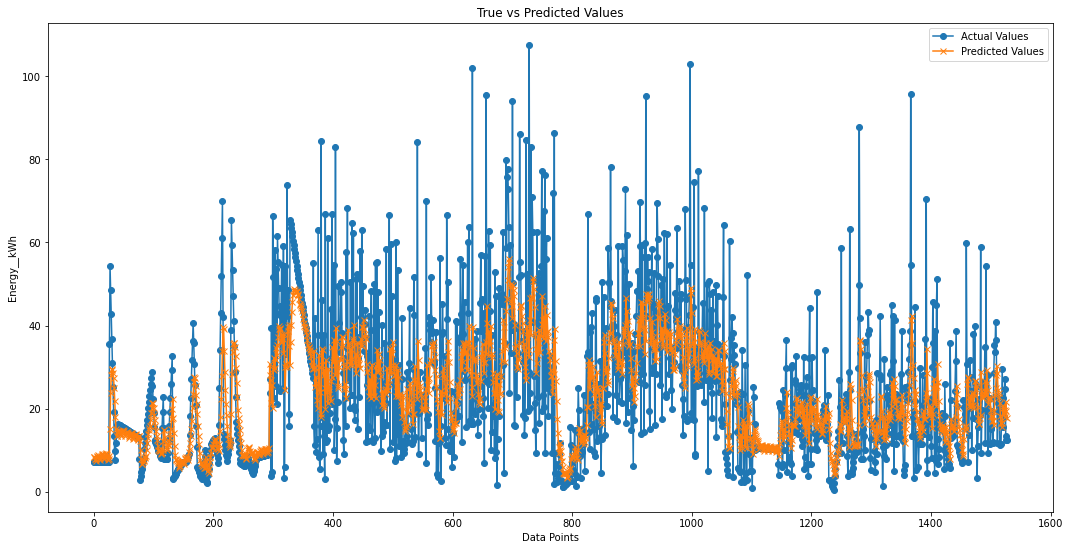

In [39]:
plt.figure(figsize=(18,9))

# Plotting true values
plt.plot(Y_test[:, 0], label='Actual Values', marker='o')

# Plotting predicted values
plt.plot(inversed_y_pred, label='Predicted Values', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Energy__kWh')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

### **One-Step Forecast**

1/1 [==============================] - 0s 82ms/step


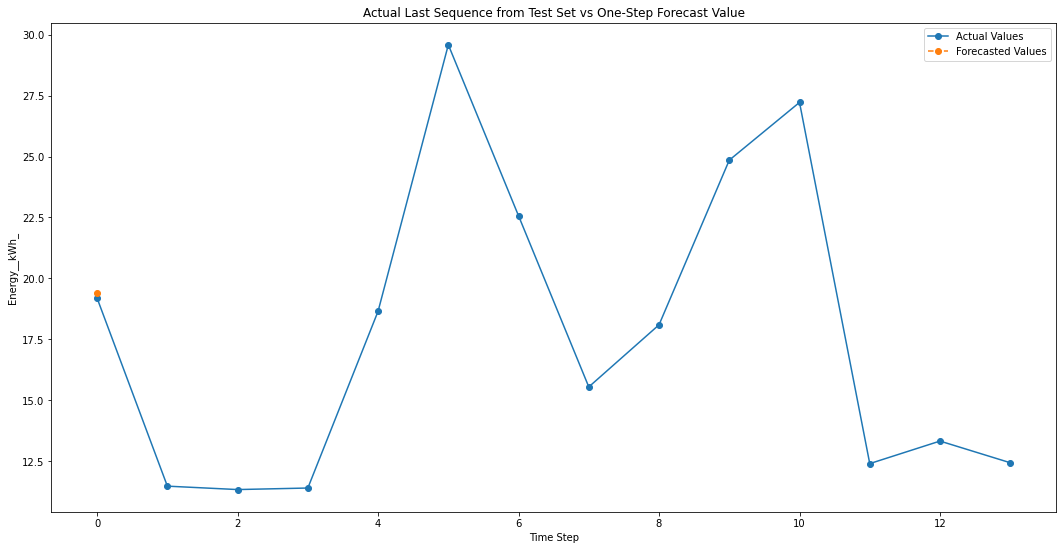

The actual value we need to predict is 19.185 kWh
The foreast value is 19.418 kWh


In [101]:
# Extract the last sequence from the test data for one-step forecasting
last_sequence = X_test_scaled[-2:-1].reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])

# Make a one-step forecast
one_step_forecast_scaled = model.predict(last_sequence)

# Inverse transform
one_step_forecast = x_scaler.inverse_transform(np.concatenate([one_step_forecast_scaled, np.zeros((one_step_forecast_scaled.shape[0], numerical_D-1))], axis=1))
one_step_forecast = one_step_forecast[0, 0]

# Assuming Y_test and y_true are NumPy arrays
y_true = Y_test[-T:, 0]

# Plotting the results
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='Actual Values', marker='o')
plt.plot(one_step_forecast, label='Forecasted Values', linestyle='dashed', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Energy__kWh_')
plt.title('Actual Last Sequence from Test Set vs One-Step Forecast Value')
plt.legend()
plt.show()

print('The actual value we need to predict is', Y_test[-T, 0], 'kWh')
print('The foreast value is' ,np.round(one_step_forecast,3), 'kWh')